# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski 1.[5 pkt]
4. Jakość kodu 0.[5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [1]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
import random
from matplotlib import pyplot as plt
import time


In [2]:
from pprint import pprint

class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate

class FullyConnected(Layer):
    def __init__(self, input_size:int, output_size:int, weights=None, multiplier=None) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size

        if multiplier is None:
            multiplier = 8
        if weights is None:
            self.weights = np.random.rand(self.input_size, self.output_size)
        else:
            self.weights = weights

        self.weights = (np.random.rand(self.input_size, self.output_size) - 0.5) / multiplier
        self.bias = (np.ones((1, output_size)) - 0.5) / multiplier


    def forward(self, x:np.ndarray)->np.ndarray:
        self.input = x
        self.output = np.matmul(x, self.weights) + self.bias

        return self.output

    def backward(self, output_error_derivative)->np.ndarray:
        self.dweights = np.matmul(self.input.T, output_error_derivative)/output_error_derivative.shape[1]
        self.dbias = np.mean(output_error_derivative, axis=0)/output_error_derivative.shape[1]
        self.weights -= self.dweights *self.learning_rate
        self.bias -= self.dbias *self.learning_rate

        return np.matmul(output_error_derivative, self.weights.T)

class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x:np.ndarray)->np.ndarray:
        self.input = x
        self.output = np.tanh(x)

        return self.output

    def backward(self, output_error_derivative)->np.ndarray:

        input_gradient = np.multiply(output_error_derivative, (1 - np.tanh(self.input)**2))

        return input_gradient

class Loss:
    def __init__(self, loss_function:callable, loss_function_derivative:callable)->None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x:np.ndarray, y)->np.ndarray:
        """Loss function for a particular x"""
        expected = np.zeros(10)
        expected[y] = 1

        return np.mean((expected-x)**2)

    @staticmethod
    def loss_derivative(x:np.ndarray, y:np.ndarray)->np.ndarray:
        """Loss function derivative for a particular x and y"""
        batch_size = x.shape[0]
        expected = np.zeros((batch_size, 10))
        for col_index, row_index in enumerate(y):
            expected[int(col_index), int(row_index)] = 1

        return 2 * (x - expected)

class Network:
    def __init__(self, layers:List[FullyConnected], learning_rate:float = 0.01)->None:
        self.layers = layers
        self.learning_rate = learning_rate
        self.layers_Tanh:List[Tanh] = []

    def __call__(self, x:np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        xs = x
        for index in range(len(self.layers)):
            self.layers[index].learning_rate = self.learning_rate
            xs = self.layers[index].forward(xs)
            if index != len(self.layers)-1:
                if len(self.layers_Tanh) == index:
                    self.layers_Tanh.append(Tanh())
                xs = self.layers_Tanh[index].forward(xs)
        return xs

    def fit(self,
            x_train:np.ndarray,
            y_train:np.ndarray,
            epochs:int,
            batch_size:int=8,
            verbose:int=0)->None:
        """Fit the network to the training data"""
        success_rates = []
        for i in range(epochs):
            if verbose:
                if verbose == 1 and i%10==0 or verbose > 1:
                    success = 0
                    for x,y in zip(x_train[:1000], y_train[:1000]):
                        if int(np.argmax(self(x))) == int(y):
                            success+=1
                    success_rates.append(success/1000)

            for batch in range(0, x_train.shape[0], batch_size):
                x_batch = x_train[batch:(batch+batch_size)]
                y_batch = y_train[batch:(batch+batch_size)]
                res = self(x_batch/100)
                for index in range(len(self.layers)-1,-1,-1):
                    if index == len(self.layers)-1:

                        grad = Loss.loss_derivative(res, y_batch)
                    else:
                        grad = self.layers_Tanh[index].backward(grad)
                    grad = self.layers[index].backward(grad)
        return success_rates


# Eksperymenty

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(*fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser='pandas'
), test_size=0.1)

In [4]:
neuron = Network([FullyConnected(784, 32), FullyConnected(32,10)], 0.003)
neuron.fit(x_train, y_train, 10, 8)
res = 0
for x,y in zip(x_test, y_test):
    if int(np.argmax(neuron(x))) == int(y):
        res+=1

print(res/y_test.shape[0])

0.8952857142857142


In [64]:
neuron = Network([FullyConnected(784, 32), FullyConnected(32,10)], 0.001)
success_rates = neuron.fit(x_train, y_train, 200, 32, 1)
res = 0
for x,y in zip(x_test, y_test):
    if int(np.argmax(neuron(x))) == int(y):
        res+=1

for n, success in enumerate(success_rates):
    print(f'{n*10}th epoch, success rate = {success*100:.3}%')

0th epoch, success rate = 8.4%
10th epoch, success rate = 87.0%
20th epoch, success rate = 88.8%
30th epoch, success rate = 88.5%
40th epoch, success rate = 90.1%
50th epoch, success rate = 91.2%
60th epoch, success rate = 90.5%
70th epoch, success rate = 91.3%
80th epoch, success rate = 90.9%
90th epoch, success rate = 91.1%
100th epoch, success rate = 91.8%
110th epoch, success rate = 91.9%
120th epoch, success rate = 92.1%
130th epoch, success rate = 92.0%
140th epoch, success rate = 92.1%
150th epoch, success rate = 91.7%
160th epoch, success rate = 92.6%
170th epoch, success rate = 92.5%
180th epoch, success rate = 92.6%
190th epoch, success rate = 93.0%


# 3 ukryte warstwy

In [8]:
for n in range(5):
    x_train, x_test, y_train, y_test = train_test_split(*fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser='pandas'
), test_size=0.1)
    neuron = Network([FullyConnected(784, 128), FullyConnected(128, 64), FullyConnected(64, 32), FullyConnected(32,10)], 0.01)
    neuron.fit(x_train, y_train, 10, 32)
    res = 0
    for x,y in zip(x_test, y_test):
        if int(np.argmax(neuron(x))) == int(y):
            res+=1

    print(f'seed {n+1}, success rate = {res/len(y_test)*100:.3}%')

seed 1, success rate = 93.6%
seed 2, success rate = 93.5%
seed 3, success rate = 93.7%
seed 4, success rate = 93.0%
seed 5, success rate = 93.2%


# 2 ukrtyte warstwy


In [88]:
for n in range(5):
    x_train, x_test, y_train, y_test = train_test_split(*fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser='pandas'
), test_size=0.1)
    neuron = Network([FullyConnected(784, 64), FullyConnected(64, 32), FullyConnected(32,10)], 0.003)
    neuron.fit(x_train, y_train, 10, 32)
    res = 0
    for x,y in zip(x_test, y_test):
        if int(np.argmax(neuron(x))) == int(y):
            res+=1

    print(f'seed {n+1}, success rate = {res/len(y_test)*100:.3}%')

seed 1, success rate = 90.6%
seed 2, success rate = 91.1%
seed 3, success rate = 91.3%
seed 4, success rate = 92.0%
seed 5, success rate = 91.5%


# 1 ukryta warstwa

In [87]:
for n in range(5):
    x_train, x_test, y_train, y_test = train_test_split(*fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser='pandas'
), test_size=0.1)
    neuron = Network([FullyConnected(784, 32), FullyConnected(32,10)], 0.003)
    neuron.fit(x_train, y_train, 10, 32)
    res = 0
    for x,y in zip(x_test, y_test):
        if int(np.argmax(neuron(x))) == int(y):
            res+=1

    print(f'seed {n+1}, success rate = {res/len(y_test)*100:.3}%')

seed 1, success rate = 89.2%
seed 2, success rate = 88.2%
seed 3, success rate = 89.0%
seed 4, success rate = 88.8%
seed 5, success rate = 89.1%


# bez ukrytych warstw

In [9]:
for n in range(5):
    x_train, x_test, y_train, y_test = train_test_split(*fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser='pandas'
), test_size=0.1)
    neuron = Network([FullyConnected(784, 10)], 0.0001)
    neuron.fit(x_train, y_train, 10, 8)
    res = 0
    for x,y in zip(x_test, y_test):
        if int(np.argmax(neuron(x))) == int(y):
            res+=1

    print(f'seed {n+1}, success rate = {res/len(y_test)*100:.3}%')

seed 1, success rate = 82.6%
seed 2, success rate = 82.6%
seed 3, success rate = 83.4%
seed 4, success rate = 82.2%
seed 5, success rate = 82.6%


# test dla różnych wag początkowych

In [84]:
weights1 = np.random.rand(784, 16)
weights2 = np.random.rand(16, 10)
for n in range(1, 10):
    neuron = Network([FullyConnected(784, 16, weights1.copy(), n), FullyConnected(16,10,weights2.copy(), n)], 0.003)
    neuron.fit(x_train, y_train, 10, 32)
    res = 0
    for x,y in zip(x_test, y_test):
        if int(np.argmax(neuron(x))) == int(y):
            res+=1

    print(f'random weights divided by {n}, success rate = {res/len(y_test)*100:.3}%')

random weights divided by 1, success rate = 71.4%
random weights divided by 2, success rate = 82.7%
random weights divided by 3, success rate = 84.5%
random weights divided by 4, success rate = 84.4%
random weights divided by 5, success rate = 84.5%
random weights divided by 6, success rate = 86.7%
random weights divided by 7, success rate = 84.2%
random weights divided by 8, success rate = 87.0%
random weights divided by 9, success rate = 84.9%


# różne learning rate'y

In [83]:
weights1 = np.random.rand(784, 16)
weights2 = np.random.rand(16, 10)
for n in range(1, 10):
    neuron = Network([FullyConnected(784, 16, weights1.copy()), FullyConnected(16,10,weights2.copy())], 0.001*n)
    neuron.fit(x_train, y_train, 10, 8)
    res = 0
    for x,y in zip(x_test, y_test):
        if int(np.argmax(neuron(x))) == int(y):
            res+=1

    print(f'learning rate = {0.001*n:.3}, success rate = {res/len(y_test)*100:.3}%')

learning rate = 0.001, success rate = 83.7%
learning rate = 0.002, success rate = 83.7%
learning rate = 0.003, success rate = 85.4%
learning rate = 0.004, success rate = 82.9%
learning rate = 0.005, success rate = 82.7%
learning rate = 0.006, success rate = 80.3%
learning rate = 0.007, success rate = 75.3%
learning rate = 0.008, success rate = 83.1%
learning rate = 0.009, success rate = 79.5%


# różne ilości w batchu

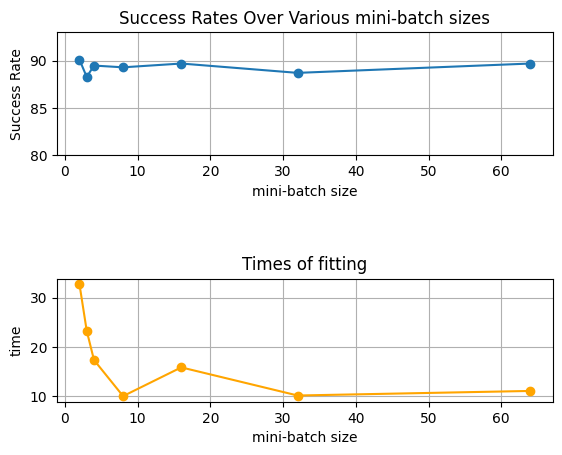

In [70]:
batches = [2,3,4,8,16,32,64]
success_rates = []
times = []
weights1 = np.random.rand(784, 32)
weights2 = np.random.rand(32, 10)
for n in batches:
    start = time.time()
    neuron = Network([FullyConnected(784, 32, weights1.copy()), FullyConnected(32,10,weights2.copy())], 0.001)
    neuron.fit(x_train, y_train, 10, n)
    stop = time.time()
    res = 0
    for x,y in zip(x_test, y_test):
        if int(np.argmax(neuron(x))) == int(y):
            res+=1

    success_rates.append(res/len(y_test)*100)
    times.append(stop-start)

plt.subplot(2, 1, 1)
plt.plot(batches, success_rates, marker='o', linestyle='-')
plt.title('Success Rates Over Various mini-batch sizes')
plt.xlabel('mini-batch size')
plt.ylabel('Success Rate')
plt.ylim(80, 93)  # Adjust the y-axis limits as needed
plt.grid(True)

# Create the second subplot (values over time)
plt.subplot(2, 1, 2)
plt.plot(batches, times, marker='o', linestyle='-', color='orange')
plt.title('Times of fitting')
plt.xlabel('mini-batch size')
plt.ylabel('time')
plt.grid(True)
plt.subplots_adjust(hspace=1)
plt.show()
# Adjust layou